# Native Notebooks

F# is a great programming language and all, but not familiar to everyone.

Also, this kind of modelling lends itself well to use in notebooks (like this one!), and the most popular language for writing notebooks like this one is Python.

Fortunately, we can use [Fable Python](https://fable.io/Fable.Python/index.html) to transpile our F# library into Python, so that more people can take advantage.

To build this for yourself, use the `start-watch.sh` script to start the fable executable. Follow the getting started guide for [Fable](https://fable.io/) and Fable Python to install the required tooling.

Once Fable has transpiled our library, you can reference it like any other Python package.

In [1]:
import out.Model.examples as examples
from out.Model.fable_modules.fable_library.list import FSharpList
import out.Model.library as library

# Define a little helper function to build relationships in python
relationshipCases = library.relationships.cases()

def buildRelationship(name, component, metadata={}):
    index = relationshipCases.index(name)
    return library.plain(library.relationships(index, component, metadata))
        

# Create our dependency service
test_dependency = library.Component(
    "test_dependency", [], "Internal", examples.random_uptime_profile(0.9), None)

test_service = library.Component(
    "my architecture", [buildRelationship("Requires", test_dependency)], "External", examples.random_uptime_profile(0.9), None)

We can now take advantage of Python packages in our notebook to model the behaviour of our architecture, or even translate it to different representations.

For example, to translate the model into a simple diagram, we'll use the [Diagrams](https://diagrams.mingrammer.com/) python package.

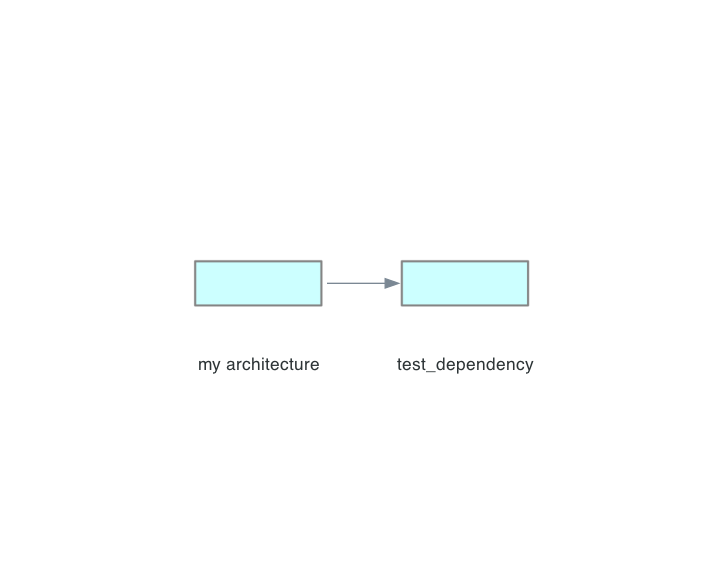

In [2]:
from diagrams import Diagram
from diagrams.programming.flowchart import Action
from out.Model import model_translations as translations


# Our library defines a `translate` function that can be used to convert a component
# We need to define steps for translating components, and relationships
def componentToDiagram (component):
    return Action(label=component.name)

def linkToDiagram (link, leaf):
    return leaf

# We also need a function to determine how to build out our new representation
def joinNodes (leaf, branches):
    for branch in branches:
        leaf >> branch
    return leaf

with Diagram(show=False) as diag:
    # We can use the `translate` function to convert our component into a diagram
    translations.translate(componentToDiagram, linkToDiagram, joinNodes, test_service)

diag

And, now we have a diagram of our architecture, generated from our programmable model.

But, we can extend relationships beyond our technical architecture, and introduce elements of our organisation into our representation. The ability to lump everything into one representation, and then filter it all back out again becomes useful later.

Let's add some teams to our organisation, and assign them responsibility for the services.

In [3]:
def compose(*components):
    return list(map(lambda c: buildRelationship("ComposedOf", c), components))

team_one = library.build_team("team one", "1")
test_service.links.append(buildRelationship("ResponsibilityOf", team_one))

team_two = library.build_team("team two", "2")
team_three = library.build_team("team three", "3")

team_one.links.append(buildRelationship("ComposedOf", team_two))

test_dependency.links.append(buildRelationship("ResponsibilityOf", team_three))

everyone = library.Component(
    "the whole org", 
    compose(team_one, team_two, team_three),
    "Team",
    library.perfect_uptime,
    None
)

We can now draw out a diagram of everything, and everyone involved in our architecture, starting from the root and pushing all the way down to the leaves.

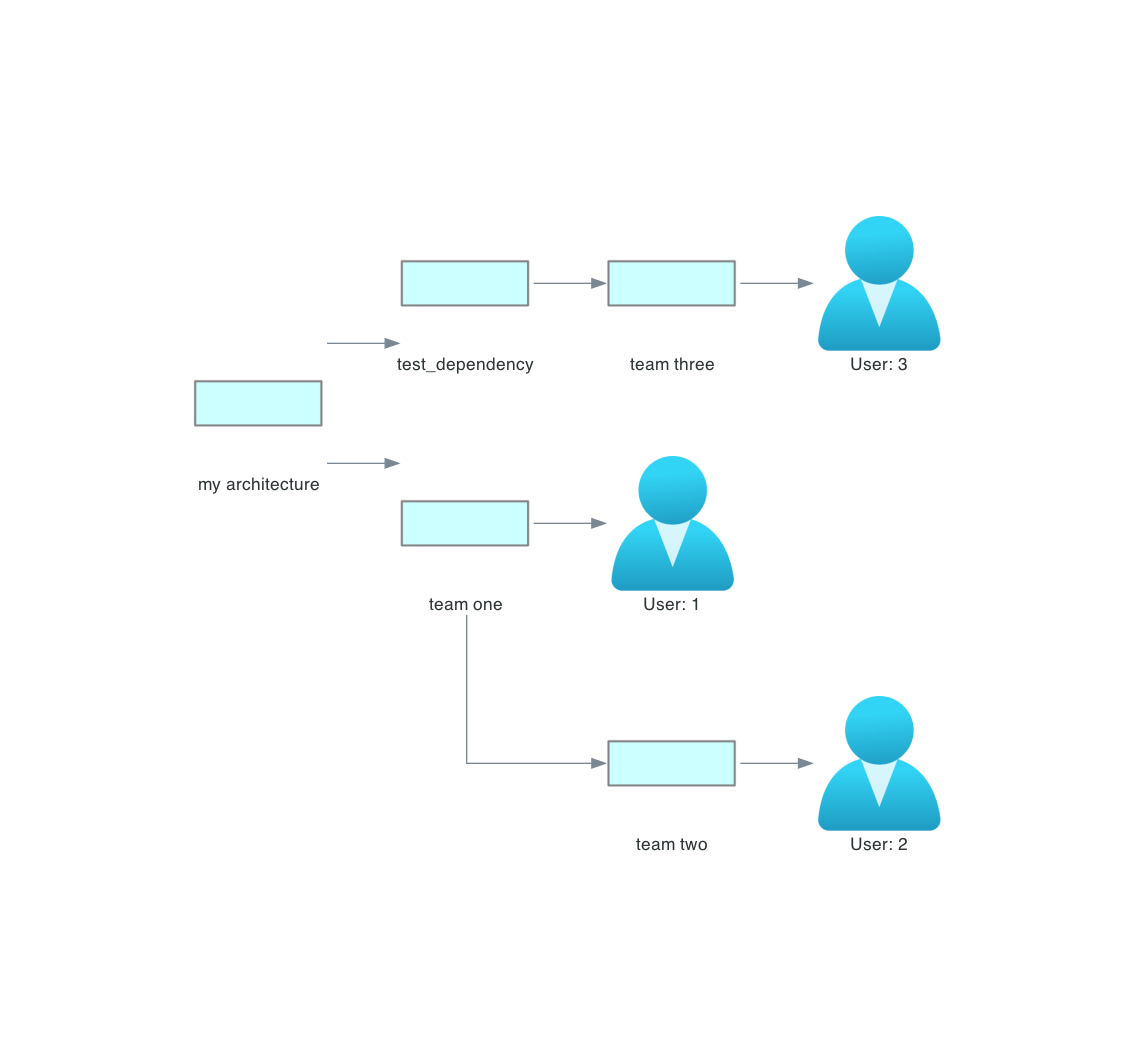

In [5]:
from diagrams.azure.identity import Users

def drawUnit (component):
    service_type = str(component.service_type)
    
    if service_type == "Individual":
        return Users(label=("User: " + component.name))
    
    
    return Action(label=component.name)



with Diagram(show=False) as diag:
    # We can use the `translate` function to convert our component into a diagram
    translations.translate(drawUnit, linkToDiagram, joinNodes, test_service)

diag

If we want a different view, we can start at a different point in our architecture, let's say we start at the top of the org, not at the aggregate for our system.

As translate just walks down the chart, and doesn't navigate back up through the relationships, we'll end up with something more like an org chart.

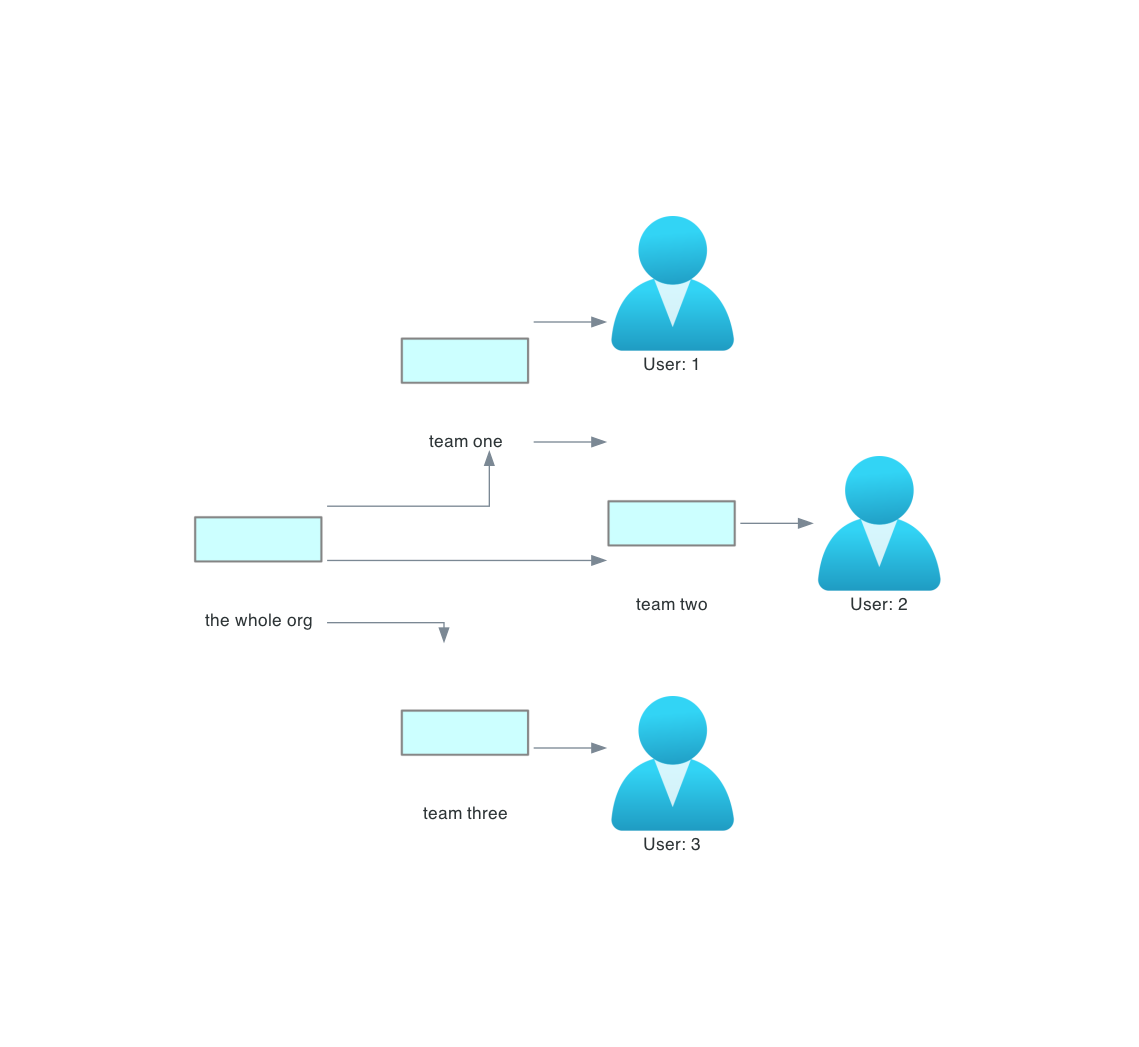

In [7]:
with Diagram(show=False) as diag:
    # We can use the `translate` function to convert our component into a diagram
    translations.translate(drawUnit, linkToDiagram, joinNodes, everyone)

diag